In [8]:
#import stuff we need
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import os
import librosa
import librosa.display
from routines import *
import warnings
warnings.filterwarnings('ignore')

In [66]:
#used for video converting
def pil_list_to_cv2(pil_list):
	#converts a list of pil images to a list of cv2 images
	png_list=[]
	for pil_img in pil_list:
		pil_img.save('trash_image.png',format='png')
		png_list.append(cv2.imread('trash_image.png'))
	os.remove('trash_image.png')
	return png_list
#generate an .avi video
def generate_video(cv2_list,path='car_race.avi',fps=10): 
	#makes a video from a given cv2 image list
	if len(cv2_list)==0:
		raise ValueError('the given png list is empty!')
	video_name = path
	frame=cv2_list[0] 
	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape   
	video = cv2.VideoWriter(video_name, 0, fps, (width, height))  
	# Appending the images to the video one by one 
	for cv2_image in cv2_list:  
	    video.write(cv2_image) 
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows()  
	video.release()  # releasing the video generated 

In [65]:
#calculating the acceleration of the system
def get_theta_dd(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	#----theta1_dd-----
	num1=-g*((2*m1+m2)*np.sin(theta1)+m2*np.sin(theta1-2*theta2))
	num2=-2*np.sin(theta1-theta2)*m2*(theta2_d**2*l2+theta1_d**2*l1*np.cos(theta1-theta2))
	denum1=2*m1+m2-m2*np.cos(2*theta1-2*theta2)
	denum=l1*denum1
	theta1_dd=(num1+num2)/denum
	#----theta2_dd----
	num1=2*np.sin(theta1-theta2)
	num2=theta1_d**2*l1*(m1+m2)+g*(m1+m2)*np.cos(theta1)+theta2_d**2*l2*m2*np.cos(theta1-theta2)
	denum=l2*denum1
	theta2_dd=num1*num2/denum
	
	return theta1_dd,theta2_dd

#calculating the systems energy
def get_energy(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	y1=l1*np.cos(theta1)
	y2=y1+l2*np.cos(theta2)
	e_pot=np.array([-m1*g*y1,-m2*g*y2])
	e_kin_1=m1/2*(l1*theta1_d)**2
	e_kin_2=(l1*theta1_d)**2
	e_kin_2+=(l2*theta2_d)**2
	e_kin_2+=2*l1*l2*theta1_d*theta2_d*(np.cos(theta1)*np.cos(theta2)+np.sin(theta1)*np.sin(theta2))
	e_kin_2*=m2/2
	e_kin=np.array([e_kin_1,e_kin_2])
	return e_pot,e_kin

def explicite_euler(dt,theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	theta1_dd,theta2_dd=get_theta_dd(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
	return theta1+dt*theta1_d,theta2+dt*theta2_d,theta1_d+dt*theta1_dd,theta2_d+dt*theta2_dd

def calculate_trajectory(n_iter,dt,theta1_init,theta2_init,theta1_d_init,theta2_d_init,m1=1,m2=1,l1=1,l2=0.5,g=10,add_energy=None):
	print('calculate phase trajectory....')
	phase_traject=np.zeros((n_iter,4))#phase-space trajectory
	phase_traject[0,:]=np.array([theta1_init,theta2_init,theta1_d_init,theta2_d_init])
	for i in range(n_iter-1):
		if i%100000==0:
			print('progress: '+str(i)+'/'+str(n_iter-1))
		if add_energy is not None:
			phase_traject[i,2]+=np.sign(phase_traject[i,2])*add_energy
		#---explicite midpoint method ----
		theta1_d_i=phase_traject[i,2]
		theta2_d_i=phase_traject[i,3]
		theta11,theta22,theta11_d,theta22_d=explicite_euler(dt/2,phase_traject[i,0],phase_traject[i,1],theta1_d_i,theta2_d_i,m1,m2,l1,l2,g)
		theta11_dd,theta22_dd=get_theta_dd(theta11,theta22,theta11_d,theta22_d,m1,m2,l1,l2,g)
		theta1_dd,theta2_dd=get_theta_dd(theta11,theta22,theta11_d,theta22_d,m1,m2,l1,l2,g)
		theta1_d=theta1_d_i+dt*theta1_dd
		theta2_d=theta2_d_i+dt*theta2_dd
		phase_traject[i+1,:]=np.array([phase_traject[i,0]+dt/2*(theta1_d_i+theta1_d),phase_traject[i,1]+dt/2*(theta2_d_i+theta2_d),theta1_d,theta2_d])
	print('done!')
	return phase_traject

def render_phase_traject(phase_traject,img_res=1,m1=1,m2=1,l1=1,l2=0.5,g=10,save_path='trash_figures/',take_frame_every=1,second_phase_traject=None):
	frames=[]
	e_pot=[]#the potential energy of each of the masses: e_pot=-m*g*y
	e_kin=[]#the kinetic energy of each of the masses: e_kin=m*l**2*theta_d**2/2
	h=int(img_res*200)
	w=2*h
	
	w_34=int(3*w/4)
	x0=int(w/4)
	y0=int(h/2)
	h_red=int(0.4*h)
	l_tot=l1+l2
	l1_ratio=l1/l_tot
	l2_ratio=l2/l_tot
	L1=l1_ratio*h_red
	L2=l2_ratio*h_red
	d=int(0.02*h)
	d1=d*m1**(1/3)
	d2=d*m2**(1/3)
	d_4=d/4
	e_pot_0,e_kin_0=get_energy(phase_traject[0,0],phase_traject[0,1],phase_traject[0,2],phase_traject[0,3],m1,m2,l1,l2,g)
	energy=np.sum(e_pot_0)+np.sum(e_kin_0)
	print('initial energy: '+str(energy))
	prev_points=[]
	prev_phase=[]
	max_points=500
	max_theta2_d=1.2*np.max(np.abs(phase_traject[:,3]))
	for i in range(phase_traject.shape[0]):
		if i%10000==0:
			print('rendering iteration: '+str(i)+'/'+str(phase_traject.shape[0]))           
		if i%take_frame_every==0:
			theta1=phase_traject[i,0]
			theta2=phase_traject[i,1]
			theta1_d=phase_traject[i,2]
			theta2_d=phase_traject[i,3]
			prev_phase.append((theta2,theta2_d))
			# theta2_d=get_corrected_theta2_d(energy,theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
			#----transform to cartesian coordinates---
			x1=x0+L1*np.sin(theta1)
			y1=y0+L1*np.cos(theta1)
			x2=x1+L2*np.sin(theta2)
			y2=y1+L2*np.cos(theta2)
			prev_points.append([np.array([x1,y1]),np.array([x2,y2])])
			#---draw the image ----
			img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			n_prev=min(max_points,len(prev_points))
			for k in range(n_prev-1):
				idx=n_prev-k
				point=prev_points[-idx]
				xx2=point[1][0]
				yy2=point[1][1]
				point=prev_points[-idx+1]
				xxx2=point[1][0]
				yyy2=point[1][1]
				intensity=int(255*(1-0.99**idx))
				draw.line([(xx2,yy2),(xxx2,yyy2)],fill=(intensity,intensity,255),width=2)
				if np.abs((prev_phase[-idx][0]+np.pi)%(2*np.pi)-(prev_phase[-idx+1][0]+np.pi)%(2*np.pi))<np.pi:
					phase_x=w_34+x0*((prev_phase[-idx][0]+np.pi)%(2*np.pi)-np.pi)/(2*np.pi)
					phase_y=y0+y0*prev_phase[-idx][1]/max_theta2_d
					phase_xx=w_34+x0*((prev_phase[-idx+1][0]+np.pi)%(2*np.pi)-np.pi)/(2*np.pi)
					phase_yy=y0+y0*prev_phase[-idx+1][1]/max_theta2_d
					draw.line([(phase_x,phase_y),(phase_xx,phase_yy)],fill=(255,intensity,intensity),width=2)
			if second_phase_traject is not None:
				x11=x0+L1*np.sin(second_phase_traject[i,0])
				y11=y0+L1*np.cos(second_phase_traject[i,0])
				x22=x11+L2*np.sin(second_phase_traject[i,1])
				y22=y11+L2*np.cos(second_phase_traject[i,1])
				draw.line([(x0,y0),(x11,y11)],fill=(255,0,0),width=1)
				draw.ellipse([(x11-d1,y11-d1),(x11+d1,y11+d1)], fill=(255,0,0), outline=None)
				draw.line([(x11,y11),(x22,y22)],fill=(255,0,0),width=1)
				draw.ellipse([(x22-d2,y22-d2),(x22+d2,y22+d2)], fill=(255,0,0), outline=None)
			draw.line([(x0,y0),(x1,y1)],fill=(0,0,0),width=1)
			draw.ellipse([(x1-d1,y1-d1),(x1+d1,y1+d1)], fill=(0,0,0), outline=None)
			draw.line([(x1,y1),(x2,y2)],fill=(0,0,0),width=1)
			draw.ellipse([(x2-d2,y2-d2),(x2+d2,y2+d2)], fill=(0,0,255), outline=None)
			frames.append(img)
			#----calculate the energies----
			e_pot_i,e_kin_i=get_energy(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
			e_pot.append(e_pot_i)
			e_kin.append(e_kin_i)

	#frames[0].save(save_path+'double_pendulum.gif',
	               #save_all=True,
	               #append_images=frames[1:],
	               #duration=40,
	               #loop=0)
	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'double_pendulum.avi',fps=1000/40)

	e_pot=np.asarray(e_pot)
	e_kin=np.asarray(e_kin)
	print('final energy: '+str(np.sum(e_pot[-1,:])+np.sum(e_kin[-1,:])))
	return e_pot,e_kin

In [94]:
theta1_init=np.pi/3
theta2_init=np.pi/2
theta1_d_init=0
theta2_d_init=0
dt=0.005
n_iter=3000000
m2=0.1
phase_traject=calculate_trajectory(n_iter,dt,theta1_init,theta2_init,theta1_d_init,theta2_d_init,m2=m2,add_energy=1e-5)

calculate phase trajectory....
progress: 0/2999999
progress: 100000/2999999
progress: 200000/2999999
progress: 300000/2999999
progress: 400000/2999999
progress: 500000/2999999
progress: 600000/2999999
progress: 700000/2999999
progress: 800000/2999999
progress: 900000/2999999
progress: 1000000/2999999
progress: 1100000/2999999
progress: 1200000/2999999
progress: 1300000/2999999
progress: 1400000/2999999
progress: 1500000/2999999
progress: 1600000/2999999
progress: 1700000/2999999
progress: 1800000/2999999
progress: 1900000/2999999
progress: 2000000/2999999
progress: 2100000/2999999
progress: 2200000/2999999
progress: 2300000/2999999
progress: 2400000/2999999
progress: 2500000/2999999
progress: 2600000/2999999
progress: 2700000/2999999
progress: 2800000/2999999
progress: 2900000/2999999
done!


evaluate the energy trajectory...


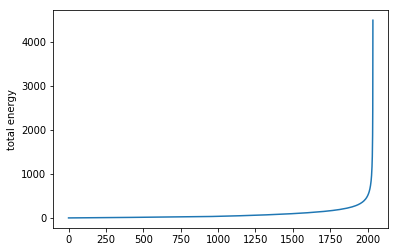

In [98]:
#plot the energy of the trajectory
total_energy=[]
print('evaluate the energy trajectory...')
calculate_every=1000
for i in range(phase_traject.shape[0]):
	if i%calculate_every==0:
		e_pot,e_kin=get_energy(phase_traject[i,0],phase_traject[i,1],phase_traject[i,2],phase_traject[i,3],m1=1,m2=m2,l1=1,l2=0.5,g=10)
		total_energy.append(np.sum(e_pot,axis=0)+np.sum(e_kin,axis=0))	
plt.plot(total_energy)
plt.ylabel('total energy')
plt.show()

initial energy: -5.500000000000001
rendering iteration: 0/10000
final energy: -5.278247116223062


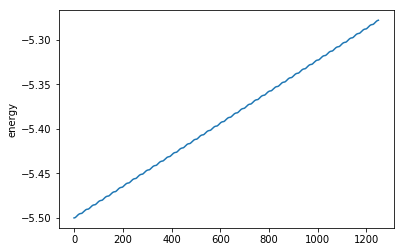

In [116]:
#render the trajectory to video
e_pot,e_kin=render_phase_traject(phase_traject[:10000],img_res=0.25,take_frame_every=int(4/dt/100),m2=m2,second_phase_traject=None)
plt.plot(np.sum(e_pot,axis=1)+np.sum(e_kin,axis=1))
plt.ylabel('energy')
plt.show()

(180000,)
progress:1/601
progress:2/601
progress:3/601
progress:4/601
progress:5/601
progress:6/601
progress:7/601
progress:8/601
progress:9/601
progress:10/601
progress:11/601
progress:12/601
progress:13/601
progress:14/601
progress:15/601
progress:16/601
progress:17/601
progress:18/601
progress:19/601
progress:20/601
progress:21/601
progress:22/601
progress:23/601
progress:24/601
progress:25/601
progress:26/601
progress:27/601
progress:28/601
progress:29/601
progress:30/601
progress:31/601
progress:32/601
progress:33/601
progress:34/601
progress:35/601
progress:36/601
progress:37/601
progress:38/601
progress:39/601
progress:40/601
progress:41/601
progress:42/601
progress:43/601
progress:44/601
progress:45/601
progress:46/601
progress:47/601
progress:48/601
progress:49/601
progress:50/601
progress:51/601
progress:52/601
progress:53/601
progress:54/601
progress:55/601
progress:56/601
progress:57/601
progress:58/601
progress:59/601
progress:60/601
progress:61/601
progress:62/601
progres

progress:494/601
progress:495/601
progress:496/601
progress:497/601
progress:498/601
progress:499/601
progress:500/601
progress:501/601
progress:502/601
progress:503/601
progress:504/601
progress:505/601
progress:506/601
progress:507/601
progress:508/601
progress:509/601
progress:510/601
progress:511/601
progress:512/601
progress:513/601
progress:514/601
progress:515/601
progress:516/601
progress:517/601
progress:518/601
progress:519/601
progress:520/601
progress:521/601
progress:522/601
progress:523/601
progress:524/601
progress:525/601
progress:526/601
progress:527/601
progress:528/601
progress:529/601
progress:530/601
progress:531/601
progress:532/601
progress:533/601
progress:534/601
progress:535/601
progress:536/601
progress:537/601
progress:538/601
progress:539/601
progress:540/601
progress:541/601
progress:542/601
progress:543/601
progress:544/601
progress:545/601
progress:546/601
progress:547/601
progress:548/601
progress:549/601
progress:550/601
progress:551/601
progress:552/6

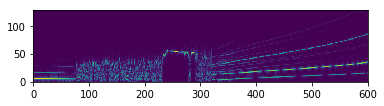

In [115]:
# render_phase_traject(phase_traject,img_res=0.5,take_frame_every=int(2/dt/100),m2=m2)
samples_inner=np.sin(phase_traject[0::10,0])
samples_delta=np.sin(phase_traject[0::10,1])
samples_outer=samples_inner+samples_delta

samples_to_render=samples_delta[:150000]
print(samples_to_render.shape)
fs=6000
librosa.output.write_wav('doublependulum_sound.mp3', samples_to_render, fs,norm=True)
time_step=0.05#ms
ns=time_step*fs
STFT=classic_STFT(ns=ns,N=256)
spec=STFT.get_energy_spec(samples_to_render)
plt.imshow(np.log(spec+1),origin='lower')
plt.show()

